# Konfigurasi Awal
Bagian konfigurasi awal untuk mendapatkan file input,
## Download from google cloud storage
Semua file input maupun output disimpan di cloud storage
### Nama file
file input: data/input-latest.csv
file output: data/output-latest.json
> Boleh juga jika modelnya ingin diexport
#### File input dikoleksi setiap hari dengan format input-timestamp.csv

In [1]:
import os

In [2]:
import sys
!{sys.executable} -m pip install python-dotenv

In [3]:
from dotenv import load_dotenv

load_dotenv()
os.environ["TFVERSION"] = "2.3"
os.environ["PYTHONVERSION"] = "3.7"

In [4]:
%%bash

mkdir -p data
gsutil -q -m cp gs://$BUCKET_NAME/data/input* data/

### Kode Machine Learning
> Masukan Kode ML dari cell ini

In [5]:
import tensorflow as tf

In [6]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None, label=''):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.title(label)

In [7]:
!wget --no-check-certificate --quiet \
    'https://docs.google.com/uc?export=download&id=1PQkLn1I9JzILnxRYyJkcRoyVcpjc7HFS' \
      -O $PROJECT_ROOT/data/sales_data_sample.csv

In [8]:
data = pd.read_csv('data/sales_data_sample.csv', encoding='Latin-1', sep=';')
data.head()

,Toko,QUANTITYORDERED,INTEREST,CUSTOMERNAME,PHONE
0,UMAY,240,2,Land of Toys Inc.,2125557818
1,UMAY,272,5,Reims Collectables,26.47.1555
2,UMAY,328,2,Lyon Souveniers,+33 1 46 62 7555
3,UMAY,360,6,Toys4GrownUps.com,6265557265
4,UMAY,392,14,Corporate Gift Ideas Co.,6505551386


In [21]:
list = data['Toko'].tolist()
toko = []
for i in list:
  if i in toko:
    pass
  else:
    toko.append(i)
toko

['UMAY',
 'Sirup jahe Dewa',
 'Sambal Mbak Ririn',
 'PAWON SOENDARI',
 'Oleh-oleh ECO',
 'Gula Semut',
 'FURNiSTIC Woodworking',
 "De'Imutz Choco",
 'Rempon_Ndoro_20',
 'Sambal Lidah Mertua']

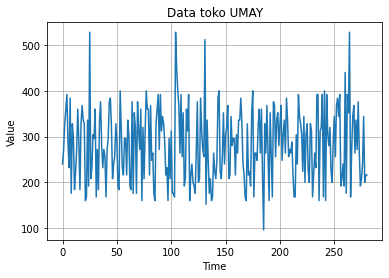

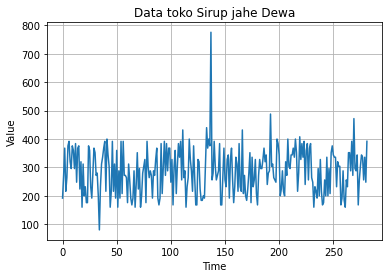

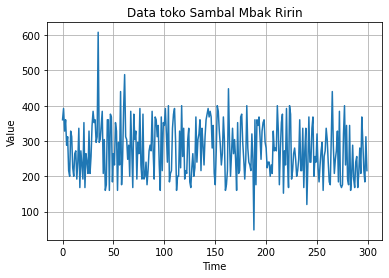

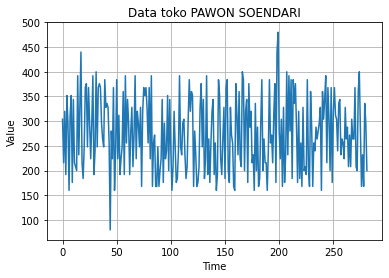

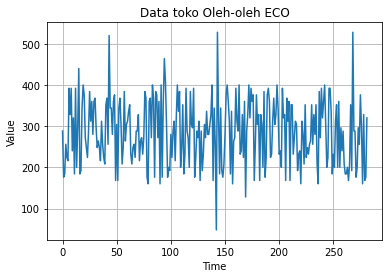

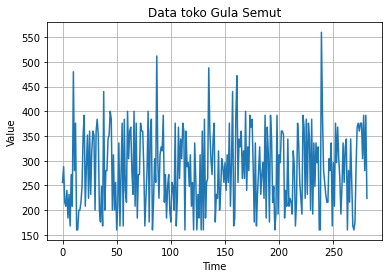

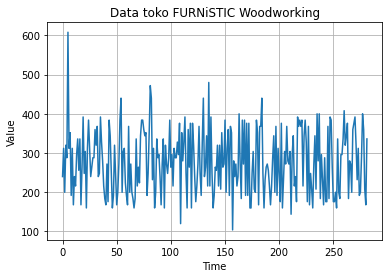

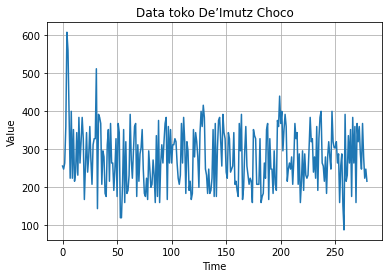

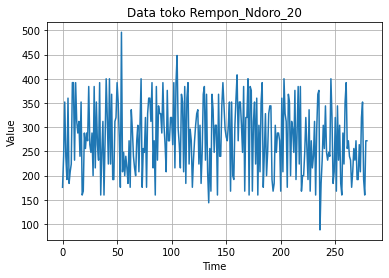

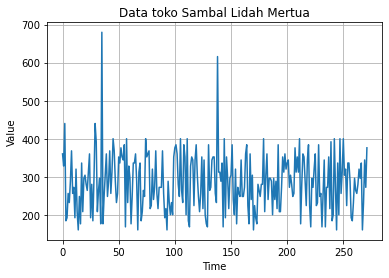

In [23]:
def prepare_data(nama):
  prep_data = data[data['Toko'] == nama]
  prep_series = prep_data['QUANTITYORDERED'].to_numpy(dtype='float64')
  prep_steps = np.arange(len(prep_data), dtype='float64')
  return prep_series, prep_steps

series_umay, steps_umay = prepare_data('UMAY')
series_sirup, steps_sirup = prepare_data('Sirup jahe Dewa')
series_sambal, steps_sambal = prepare_data('Sambal Mbak Ririn')
series_pawon, steps_pawon = prepare_data('PAWON SOENDARI')
series_oleh, steps_oleh = prepare_data('Oleh-oleh ECO')
series_gula, steps_gula = prepare_data('Gula Semut')
series_wood, steps_wood = prepare_data('FURNiSTIC Woodworking')
series_choco, steps_choco = prepare_data("De'Imutz Choco")
series_rempon, steps_rempon = prepare_data('Rempon_Ndoro_20')
series_lidah, steps_lidah = prepare_data('Sambal Lidah Mertua')

plt.show(plot_series(steps_umay, series_umay, label='Data toko UMAY'))
plt.show(plot_series(steps_sirup, series_sirup, label='Data toko Sirup jahe Dewa'))
plt.show(plot_series(steps_sambal, series_sambal, label='Data toko Sambal Mbak Ririn'))
plt.show(plot_series(steps_pawon, series_pawon, label='Data toko PAWON SOENDARI'))
plt.show(plot_series(steps_oleh, series_oleh, label='Data toko Oleh-oleh ECO'))
plt.show(plot_series(steps_gula, series_gula, label='Data toko Gula Semut'))
plt.show(plot_series(steps_wood, series_wood, label='Data toko FURNiSTIC Woodworking'))
plt.show(plot_series(steps_choco, series_choco, label='Data toko De’Imutz Choco'))
plt.show(plot_series(steps_rempon, series_rempon, label='Data toko Rempon_Ndoro_20'))
plt.show(plot_series(steps_lidah, series_lidah, label='Data toko Sambal Lidah Mertua'))

In [30]:
split_time = 250
time_train = steps_umay[:split_time]
x_train = series_umay[:split_time]
time_valid = steps_umay[split_time:]
x_valid = series_umay[split_time:]

window_size = 100
batch_size = 16
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size=10):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    
def plot_forecast(series):
    rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
    rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
    return plt.figure(figsize=(10, 6)), plot_series(time_valid, x_valid), plot_series(time_valid, rnn_forecast)

def forecast_new(series, Toko, ID, steps=1):
    #forecast
    _based_series = series[-window_size:]
    results = []
    for i in range(steps):
        _based_series = _based_series[-window_size:]
        _r = model_forecast(model, _based_series.reshape(-1,1),window_size)[-1,-1]
        results.append(_r[0])
        _based_series = np.append(_based_series,_r)
    results = np.array(results)
    js = results.tolist()
    rn = {
        'Toko' : Toko,
        'ID' : ID,
        'forecast' : js
    }
    json_str = json.dumps(rn)
    return json_str

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=800)


Epoch 1/800
10/10 [==============================] - 2s 223ms/step - loss: 174.3219 - mae: 174.8216
Epoch 2/800
10/10 [==============================] - 2s 219ms/step - loss: 76.5986 - mae: 77.0974
Epoch 3/800
10/10 [==============================] - 2s 243ms/step - loss: 68.8598 - mae: 69.3587
Epoch 4/800
10/10 [==============================] - 3s 251ms/step - loss: 67.8071 - mae: 68.3058
Epoch 5/800
10/10 [==============================] - 2s 208ms/step - loss: 67.2519 - mae: 67.7507
Epoch 6/800
10/10 [==============================] - 2s 210ms/step - loss: 66.9392 - mae: 67.4375
Epoch 7/800
10/10 [==============================] - 2s 232ms/step - loss: 66.7242 - mae: 67.2224
Epoch 8/800
10/10 [==============================] - 2s 235ms/step - loss: 66.6178 - mae: 67.1165
Epoch 9/800
10/10 [==============================] - 2s 227ms/step - loss: 66.5363 - mae: 67.0354
Epoch 10/800
10/10 [==============================] - 2s 242ms/step - loss: 66.3528 - mae: 66.8498
Epoch 11/800
10/1

(<Figure size 720x432 with 1 Axes>, None, None)

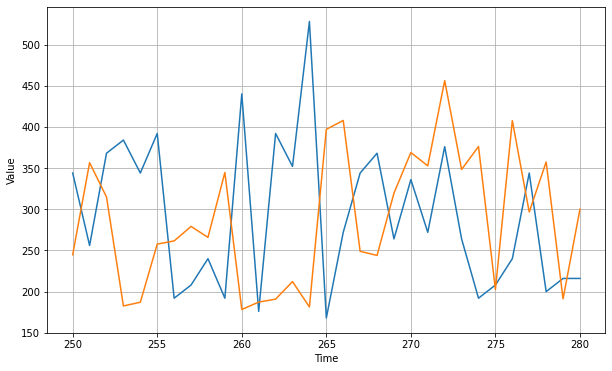

In [31]:
plot_umay = plot_forecast(series_umay)
plot_umay

In [34]:
forecast_umay = forecast_new(series_umay, Toko='Oleh-oleh ECO', ID=1, steps=30)
print(forecast_umay)
with open("data/output-latest.json", "w") as file:
    file.write(forecast_umay)

{"Toko": "Oleh-oleh ECO", "ID": 1, "forecast": [483.418212890625, 417.62982177734375, 411.1540832519531, 352.4342041015625, 288.5237731933594, 279.8297424316406, 231.8590087890625, 270.0309143066406, 212.23435974121094, 284.32940673828125, 207.37481689453125, 274.07183837890625, 191.59481811523438, 222.59719848632812, 208.12364196777344, 417.1957092285156, 350.62347412109375, 294.8687438964844, 172.38153076171875, 267.0450439453125, 301.0193786621094, 231.62217712402344, 350.9587707519531, 183.8987274169922, 211.66058349609375, 170.75338745117188, 457.1097717285156, 377.54730224609375, 405.5428466796875, 340.9356994628906]}


### Upload file output
File output diupload ke cloud storage

#### Format file output: 
`output-latest.json` dan `output-[timestamp].json`, boleh juga kalau mau upload bentuk lainnya (misal HDF5 nya dll.)
> Pastikan output **disimpan ke direktori data**

In [50]:
%%bash

gsutil -q cp data/output* gs://$BUCKET_NAME/data/